In [226]:
import graphviz as gv
import networkx as nx

from collections import defaultdict

FOLDER = '../../../data/protean/hycc_d8_ex'

In [227]:
def split_csv_line(line: str, delim=',') -> list[str]:
    dat = []
    in_quote = False
    curr = []
    for c in line:
        if c == '\"':
            in_quote = not in_quote
        elif c == ',':
            if in_quote:
                curr.append(c)
            else:
                dat.append(''.join(curr))
                curr = []
        else:
            curr.append(c)
    dat.append(''.join(curr))
    return dat

In [228]:
def get_qes_maps() -> tuple[dict[int, str], dict[str,int]]:
    # Returns detector_to_check and check_to_color maps
    qes_file = f'{FOLDER}/memory/zrm1.qes'
    with open(qes_file, 'r') as reader:
        lines = reader.readlines()
    # Go through lines and map detectors to checks
    d2c = {}    # detector to check
    c2c = {}    # check to color
    check = None
    color = None
    for line in lines:
        if check is None:
            if '@annotation' not in line:
                continue
            dat = line.split(' ')
            name = dat[-1]
            if name[0] != 'x' and name[0] != 'z':
                continue
            check = name.strip()
        elif color is None:
            if '@property color' not in line:
                continue
            dat = line.split(' ')
            color = int(dat[-1]) 
        else:
            if 'event' not in line:
                continue
            dat = line.split(' ')
            args = dat[-1].split(',')
            eventno = int(args[0])
            d2c[eventno] = check
            c2c[check] = color
            check = None
            color = None
    return d2c, c2c

In [229]:
def get_support_map() -> tuple[dict[str, list[int]], dict[int, list[str]]]:
    tg_file = f'{FOLDER}/tanner_graph.txt'
    with open(tg_file, 'r') as reader:
        lines = reader.readlines()[1:] # Ignore header.
    support_map = {}
    rev_support_map = defaultdict(list)
    for line in lines:
        dat = split_csv_line(line)
        check = dat[0]
        supp = set([int(x) for x in dat[2].split(',')])
        support_map[check] = supp
        for x in supp:
            rev_support_map[x].append(check)
    return support_map, rev_support_map

In [230]:
d2c, c2c = get_qes_maps()
support_map, rev_support_map = get_support_map()

def get_common(x, y):
    comm = support_map[x] & support_map[y]
    checks = []
    for q in comm:
        for z in rev_support_map[q]:
            if z[0] == 'z' and z != x and z != y:
                checks.append(z)
    return checks

def make_interaction_graph(checks: list[str]) -> nx.Graph:
    gr = nx.Graph()
    for x in checks:
        gr.add_node(x, color=c2c[x])
    # Add edges. Label them by common data qubits.
    for (i, ch1) in enumerate(checks):
        supp1 = support_map[ch1]
        for (j, ch2) in enumerate(checks):
            if i >= j:
                continue
            supp2 = support_map[ch2]
            comm = supp1 & supp2
            if len(comm) > 0:
                gr.add_edge(ch1, ch2, data=comm)
    return gr
                

In [231]:
RED = '#ff0000'
GREEN = '#00ff00'
BLUE = '#0000ff'
DARK = '#000000'
LIGHT = '#ffffff'

def get_color(c):
    if c == 0:
        return RED
    elif c == 1:
        return GREEN
    elif c == 2:
        return BLUE

def get_fontcolor(c):
    if c == 2:
        return LIGHT
    else:
        return DARK

def draw_interaction_graph(
    output_file: str,
    dets: list[list[int]]
):
    for arr in dets:
        print([f'{x} --> {d2c[x]}' for x in arr])
    checks = [[d2c[x] for x in arr] for arr in dets]
    all_checks = [*checks[0], *checks[1], *checks[2]]
    gr = make_interaction_graph(all_checks)

    g = gv.Graph(filename=f'error_example_graphs/{output_file}', engine='dot')
    for x in gr.nodes():
        c = gr.nodes[x]['color']
        if x in checks[0]:
            shape = 'doublecircle'
            style = 'solid'
        elif x in checks[1]:
            shape = 'circle'
            style = 'solid'
        else:
            shape = 'circle'
            style = 'dashed'
        g.node(x, style=f'filled,{style}', fillcolor=get_color(c), fontcolor=get_fontcolor(c), shape=shape, fontsize='12')
    for (x, y) in gr.edges():
        data = gr.edges[x,y]['data']
        data_str = ','.join([str(x) for x in data])
        if x in checks[2] or y in checks[2]:
            style = 'dashed'
        else:
            style = 'solid'
        g.edge(x, y, style=style, label=data_str, fontsize='8')
    return g

['196 --> z295', '216 --> z313', '265 --> z284']
['211 --> z308', '197 --> z294', '255 --> z274']
['195 --> z287', '189 --> z307']


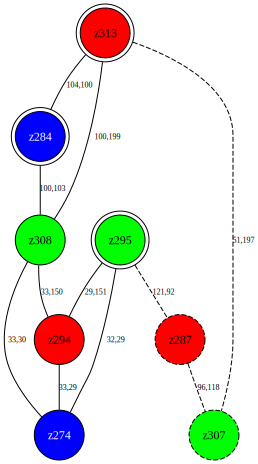

In [232]:
# EXAMPLE 1:
dets = [
    [196, 216, 265],
    [211, 197, 255],
    [195, 189]
]
draw_interaction_graph('ex1.pdf', dets)

['190 --> z306', '205 --> z291', '222 --> z319', '228 --> z325', '252 --> z271']
['236 --> z333', '241 --> z338']
['250 --> z347', '249 --> z346']


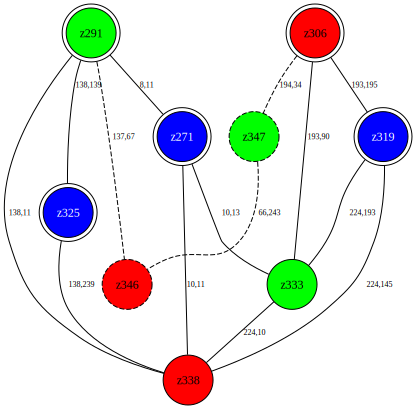

In [233]:
# EXAMPLE 2
dets = [
    [190, 205, 222, 228, 252],
    [236, 241],
    [250, 249]
]
draw_interaction_graph('ex2.pdf', dets)

['234 --> z331', '236 --> z333', '243 --> z340', '256 --> z275', '259 --> z278']
['206 --> z302', '242 --> z339']
['244 --> z341', '248 --> z345']


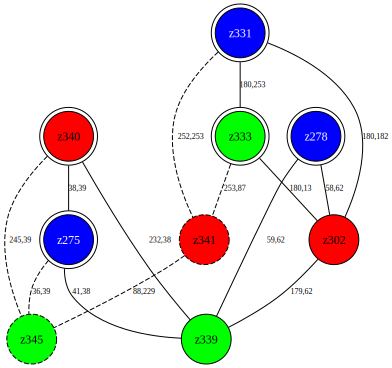

In [234]:
# EXAMPLE 3 (WITH WEIGHTING 1.0 -- only SQRT for hyperedges with 2 flipped detectors)
dets = [
    [234, 236, 243, 256, 259],
    [206, 242],
    [244, 248]
]
draw_interaction_graph('ex3.pdf', dets)

['z323', 'z285'] ['z331', 'z277'] ['z331', 'z282']
['236 --> z333', '245 --> z342', '263 --> z282']
['250 --> z347', '255 --> z274', '190 --> z306']
['244 --> z341', '247 --> z344']


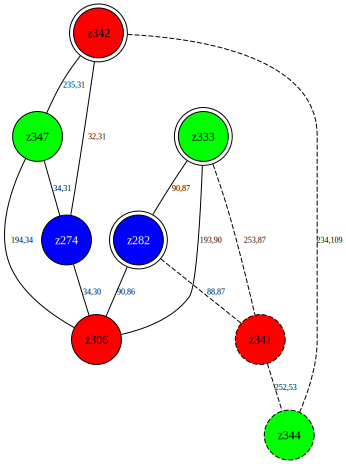

In [239]:
# EXAMPLE 4 (WITH WEIGHTING 2.0 -- 1.0 + 2p for hyperedges with one flipped detector)
dets = [
    [236, 245, 263],
    [250, 255, 190],
    [244, 247]
]
print(get_common('z342', 'z344'), get_common('z344', 'z341'), get_common('z333', 'z341'))
draw_interaction_graph('ex4.pdf', dets)

['250 --> z340', '264 --> z354', '278 --> z368', '279 --> z369', '290 --> z380']
['245 --> z335', '261 --> z351']
['220 --> z310', '301 --> z391']


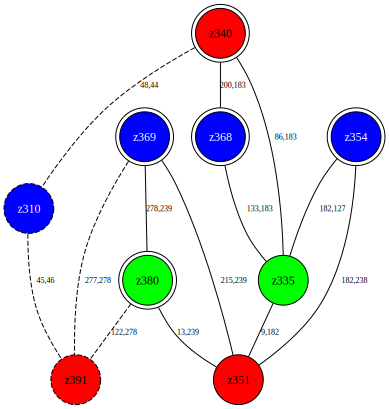

In [224]:
# With 214_40_8_8 instead of 192_36_8_8

dets = [
    [250, 264, 278, 279, 290],
    [245, 261],
    [220, 301]
]
draw_interaction_graph('ex4.pdf', dets)